# Data Mining / Prospecção de Dados

## Sara C. Madeira and André Falcão, 2019/20

# Project 1 - Pattern Mining

## Logistics

**In a "normal" scenario students should work in teams of 2 people. Due to the social distance imposed by current public health situation, students were allowed to work in groups of 1 and 3. In this context, the amount of work was adapted according to the number of students in groups as described below.**

* Task **1.** should be done by **all** groups
* Task **2.1.** should be done by **all** groups
* Task **2.2.** should be done only by **groups of 2 and 3** students
* Task **2.3** should be done only by **groups of 2 and 3** students
* Task **2.4** should be done only by **groups of 3** students
* Task **2.5** should be done only by **groups of 3** students

The quality of the project will then dictate its grade.

**The project's solution should be uploaded in Moodle before the end of April, 26th 2020 (23:59).** 

**It is mandatory to produce a Jupyter notebook containing code and text/images/tables/etc describing the solution and the results. Projects not delivered in this format will not be graded. Note that you can use `PD_201920_Project.ipynb`as template.**

Students should **upload a `.zip` file** containing all the files necessary for project evaluation. 

**Decisions should be justified and results should be critically discussed.**

## Dataset and Tools

In this project you should use [Python 3](https://www.python.org), [Jupyter Notebook](http://jupyter.org) and **[MLxtend](http://rasbt.github.io/mlxtend/)**. When using MLxtend, frequent patterns can either be discovered using `Apriori` and `FP-Growth`. **Choose the pattern mining algorithm to be used.** 

The dataset to be analysed is **`Foodmart_2020_PD.csv`**, a modified version of the [Foodmart 2000(2005) dataset](https://github.com/neo4j-examples/neo4j-foodmart-dataset/tree/master/data). 

**`Foodmart_2020_PD.csv`** stores **69549 transactions** from **24 stores**, where **103 different products** can be bought. Each transaction (row) has a STORE_ID (integer from 1 to 24), and a list of products (items), together with the quantities bought. In the transation highlighted below, a customer bought 1 unit of soup, 2 of cheese and 1 of wine at store 2.

<img src="Foodmart_2020_PD_Example.png" alt="Foodmart_2020_PD_Example" style="width: 1000px;"/>

**In what follows keep the following question in mind and be creative!**

1. What are the most popular products?
2. Which products are bought together?
3. Can you find associations highliting that when people buy a product/set of products also buy other product(s)?

## 0. Imports

Imports are done here

In [242]:
import pandas as pd
import numpy as np
from mlxtend.preprocessing import TransactionEncoder
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori, fpgrowth
from mlxtend.frequent_patterns import association_rules

## 1. Mining Frequent Itemsets and Association Rules: Ignoring Product Quantities and Stores

In this first part of the project you should load and preprocessed the dataset **`Foodmart_2020_PD.csv`** in order to compute frequent itemsets and generate association rules considering all the transactions, regardeless of the store, and ignoring product quantities.

### 1.1. Load and Preprocess Dataset

 **Product quantities and stores should not be considered.**

Load the data

In [243]:
itemset = pd.read_csv('./data/Foodmart_2020_PD.csv', delimiter = ';')
itemset.shape

(69549, 11)

Our dataset consists of 69549 transactions 

In [244]:
itemset.head()

,Column1,Column2,Column3,Column4,Column5,Column6,Column7,Column8,Column9,Column10,Column11
0,STORE_ID=2,Pasta=3,Soup=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,STORE_ID=2,Soup=1,Fresh Vegetables=3,Milk=3,Plastic Utensils=2,NaN,NaN,NaN,NaN,NaN,NaN
2,STORE_ID=2,Cheese=2,Deodorizers=1,Hard Candy=2,Jam=2,NaN,NaN,NaN,NaN,NaN,NaN
3,STORE_ID=2,Fresh Vegetables=2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,STORE_ID=2,Cleaners=1,Cookies=2,Eggs=2,Preserves=1,NaN,NaN,NaN,NaN,NaN,NaN


**Preprocessing**

In [245]:
preprocessing = False
preprocessed_data_path = 'data/data_preprocessed.npy'

In [246]:
def clear_quantities(x):
    if isinstance(x,str):
        item = x.split('=')
        return item[0]
    else:
        return x

Remove store column from dataset and clear quantities.

In [247]:
if preprocessing == True:
    #remove store column
    itemset = itemset.loc[:,'Column2':'Column11']
    #clear quantities
    itemset = itemset.applymap(clear_quantities)

Remove nan values 

In [248]:
if preprocessing == True:
    
    #remove nan values
    transactions_cleaned = []
    for i, t in enumerate(itemset.values):
        transaction = []
        for v in t:
            if isinstance(v,str): transaction.append(v)
        transactions_cleaned.append(transaction)
        
    #save preprocessed data 
    np.save(preprocessed_data_path,np.array(transactions_cleaned))
    
#load the data
else: transactions_cleaned = np.load(preprocessed_data_path, allow_pickle = True)

Apply transaction encoder

In [249]:
te = TransactionEncoder()
te_ary = te.fit(transactions_cleaned).transform(transactions_cleaned)
df_te = pd.DataFrame(te_ary, columns=te.columns_)
df_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


**Most frequent products**

Compute the most frequent products

In [250]:
df_products_frequency = pd.DataFrame()
for c in df_te.columns:
    df_c = df_te[c].value_counts().to_frame('count')
    total = int(df_c[df_c.index == True]['count']) # Count True values
    df_products_frequency = df_products_frequency.append({'product':c,'total': total,'support':(total/len(itemset))},ignore_index = True)
df_products_frequency = df_products_frequency.sort_values('total',ascending = False).reset_index(drop=True)

# Making it more presentable
df_products_frequency['support'] = df_products_frequency['support'].astype('float64').round(3)
df_products_frequency['total'] = df_products_frequency['total'].astype('int64')

df_products_frequency.head()

,product,support,total
0,Fresh Vegetables,0.284,19764
1,Fresh Fruit,0.175,12187
2,Soup,0.120,8350
3,Cheese,0.118,8193
4,Dried Fruit,0.117,8152


Compute some statistic metrics about the total column

In [251]:
df_products_frequency.total.describe()

count      102.000000
mean      2834.500000
std       2589.666372
min        895.000000
25%        971.000000
50%       1991.000000
75%       3747.500000
max      19764.000000
Name: total, dtype: float64

We can see that on average each product appears in 2834 transactions. The less bought product appears in 895 transactions, and the most bought product appears in 19764 transactions.

Now lets plot the 20 most frequent bought products

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

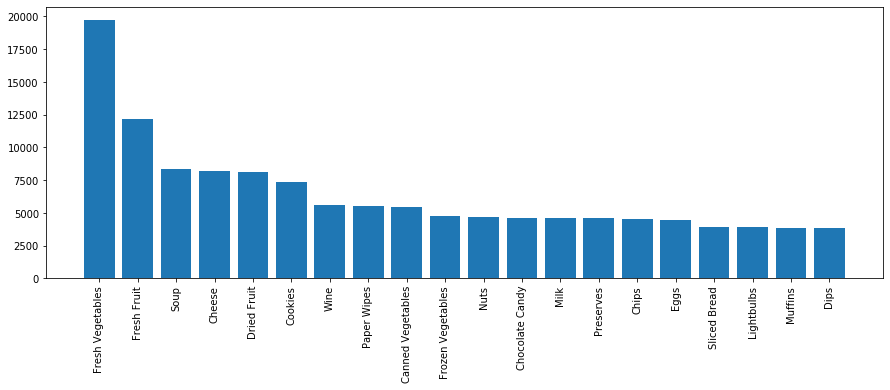

In [252]:
plt.figure(figsize=(15,5))
df_graph = df_products_frequency.iloc[:20]
plt.bar(df_graph['product'],df_graph['total'])
plt.xticks(rotation=90)

The product that appears in most transactions is 'Fresh Vegatables', which has a support of +- 0.28 (meaning that appears in 28% of the transactions).

### 1.2. Compute Frequent Itemsets

* Compute frequent itemsets considering a minimum support of X%. 
* Present frequent itemsets organized by length (number of items). 
* List frequent 1-itemsets, 2-itemsets, 3-itemsets, etc with support of at least Y%.
* Change X and Y when it makes sense and discuss the results.

In [253]:
X = 0.005
Y = 0.007

### 1.2.1 Using apriori algorithm

In [198]:
%timeit apriori(df_te, min_support=X, use_colnames=True)

8.35 s ± 252 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [199]:
frequent_itemsets  = apriori(df_te, min_support=X, use_colnames=True)
frequent_itemsets = frequent_itemsets.sort_values('support',ascending = False)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets['num_transactions'] = [round(s*len(itemset)) for s in frequent_itemsets['support']]

In [200]:
frequent_itemsets.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
40,0.284174,(Fresh Vegetables),1,19764
39,0.175229,(Fresh Fruit),1,12187
86,0.120059,(Soup),1,8350
12,0.117802,(Cheese),1,8193
31,0.117212,(Dried Fruit),1,8152
...,...,...,...,...
3,0.013343,(Auto Magazines),1,928
79,0.013271,(Sauces),1,923
34,0.013156,(Fashion Magazines),1,915
62,0.012998,(Pancakes),1,904


In [201]:
frequent_itemsets.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
268,0.050914,"(Fresh Fruit, Fresh Vegetables)",2,3541
332,0.035443,"(Soup, Fresh Vegetables)",2,2465
235,0.035227,"(Dried Fruit, Fresh Vegetables)",2,2450
146,0.031144,"(Cheese, Fresh Vegetables)",2,2166
195,0.027721,"(Cookies, Fresh Vegetables)",2,1928
...,...,...,...,...
112,0.007031,"(Bologna, Fresh Fruit)",2,489
200,0.007031,"(Cookies, Milk)",2,489
167,0.007017,"(Wine, Cheese)",2,488
297,0.007002,"(Fresh Fruit, Spices)",2,487


In [202]:
frequent_itemsets.query(f'length == 3 & support > {Y}')

,support,itemsets,length,num_transactions
372,0.007045,"(Soup, Fresh Fruit, Fresh Vegetables)",3,490


In [203]:
frequent_itemsets.query(f'length == 4 & support > {Y}')

,support,itemsets,length,num_transactions


### 1.2.2 Using FP-Growth

In [254]:
%timeit fpgrowth(df_te, min_support=X, use_colnames=True)

959 ms ± 71.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [255]:
frequent_itemsets_fpg  = fpgrowth(df_te, min_support=X, use_colnames=True)
frequent_itemsets_fpg = frequent_itemsets_fpg.sort_values('support',ascending = False)
frequent_itemsets_fpg['length'] = frequent_itemsets_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets_fpg['num_transactions'] = [round(s*len(itemset)) for s in frequent_itemsets_fpg['support']]

In [256]:
frequent_itemsets_fpg.query(f'length == 1 & support > {Y}')

,support,itemsets,length,num_transactions
2,0.284174,(Fresh Vegetables),1,19764
29,0.175229,(Fresh Fruit),1,12187
0,0.120059,(Soup),1,8350
5,0.117802,(Cheese),1,8193
32,0.117212,(Dried Fruit),1,8152
...,...,...,...,...
100,0.013343,(Sardines),1,928
34,0.013271,(Sauces),1,923
83,0.013156,(Fashion Magazines),1,915
95,0.012998,(Pancakes),1,904


In [257]:
frequent_itemsets_fpg.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
211,0.050914,"(Fresh Fruit, Fresh Vegetables)",2,3541
102,0.035443,"(Soup, Fresh Vegetables)",2,2465
223,0.035227,"(Dried Fruit, Fresh Vegetables)",2,2450
122,0.031144,"(Cheese, Fresh Vegetables)",2,2166
129,0.027721,"(Cookies, Fresh Vegetables)",2,1928
...,...,...,...,...
207,0.007031,"(Bologna, Fresh Fruit)",2,489
113,0.007031,"(Cookies, Milk)",2,489
358,0.007017,"(Wine, Cheese)",2,488
261,0.007002,"(Soda, Dried Fruit)",2,487


In [258]:
frequent_itemsets_fpg.query(f'length == 3 & support > {Y}')

,support,itemsets,length,num_transactions
104,0.007045,"(Soup, Fresh Fruit, Fresh Vegetables)",3,490


### Comments

Considering that FP Growth is using a highly compact FP-tree, divide-and-conquer method, it will be faster than Apriori for this larger database.
We can observe this by the 10x increase in speed. Both results are the same.

About the results, they normally translate the frequency of a certain set of items being bought, and the higher the length of the set, the lower generally is the support. We can see this by having only one example for a length of 3 and more than 100 examples for length of 1 and 2.

### 1.3. Generate Association Rules from Frequent Itemsets

* Generate association rules with a minimum confidence of C%. 
* Generate association rules with a minimum lift L. 
* Generate association rules with both confidence >= % and lift >= 1.1.
* Change C and L when it makes sense and discuss the results.

In [259]:
C = 0.3 # Confidence
L = 1.1 # Lift

In [260]:
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)
rules['antecedent_len'] = rules['antecedents'].apply(lambda x: len(x))

In [261]:
def generate_fi(rules, length, C, L):
    return rules[ (rules['antecedent_len'] >= length) &
         (rules['confidence'] >= C) &
         (rules['lift'] > L)]

In [262]:
generate_fi(rules, 1, C, L)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
170,(Hamburger),(Fresh Vegetables),0.028297,0.284174,0.008943,0.316057,1.112196,0.000902,1.046617,1
182,(Aspirin),(Fresh Vegetables),0.026657,0.284174,0.008598,0.322546,1.135030,0.001023,1.056642,1
308,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.020748,0.284174,0.007045,0.339570,1.194939,0.001149,1.083880,2


### Comments

We can consider that anything with a confidence below 0.5 is 'not so confident' but a lift over 1 makes it likely to happen. Therefore the top 3 rules found for this frequent itemsets are the ones above.

+ If someone buys an Hamburguer, they buy Fresh Vegetables
+ If someone buys Aspirin, they buy Fresh Vegetables
+ If someone buys Soup and Fresh Fruit, they buy Fresh Vegetables

### 1.4. Take a Look at Maximal Patterns: Compute Maximal Frequent Itemsets

In [263]:
# Frequent_itemsets with support >= 0.005

maximal_itemsets = frequent_itemsets
for row in frequent_itemsets.index:
    for comparison_row in frequent_itemsets.index:
        if row == comparison_row:
            continue
        if frequent_itemsets['itemsets'][row].issubset(frequent_itemsets['itemsets'][comparison_row]):
            maximal_itemsets = maximal_itemsets.drop([row], axis=0)
            break

In [264]:
maximal_itemsets

,support,itemsets,length,num_transactions
235,0.035227,"(Dried Fruit, Fresh Vegetables)",2,2450
318,0.022703,"(Paper Wipes, Fresh Vegetables)",2,1579
120,0.022042,"(Canned Vegetables, Fresh Vegetables)",2,1533
340,0.020432,"(Wine, Fresh Vegetables)",2,1421
316,0.019756,"(Nuts, Fresh Vegetables)",2,1374
...,...,...,...,...
233,0.005018,"(Dried Fruit, French Fries)",2,349
191,0.005018,"(Dips, Cookies)",2,349
196,0.005018,"(Cookies, Frozen Chicken)",2,349
346,0.005004,"(Paper Wipes, Lightbulbs)",2,348


### Comments

There was an option to use FPmax from MLExtend to find the maximal frequent itemsets, but a bug in the code did not allow us to use it. Still, the algorithm is simple enough. Maximal Frequent Itemsets are sets of items that do not have any superset that is also frequent. Out algorithm is not very efficient but still allows us to obtain it.

Maximal Patterns show us well supported sets which happen without any other frequent superset. Therefore we can say:

        "Pasta and Cheese is a frequent set, and there is no superset that contains these items and is frequent"

### 1.5 Conclusions from Mining Frequent Patterns in All Stores

The transactions we have, as we can note, are from supermarkets or grocery stores; We will not be able to see sets of specific items from each store since the support is represented by: `(number of transactions where A is presents)/(all transactions)`. Bigger stores will dominate the dataset in this way.

A better approach would be do do an analysis for specific stores, as we will do after.

It is interesting to note that buying Dried Fruits and Fresh Vegetables together represents 3% of all transactions, making it fair to say that it is a common thing to happen when people go shopping in comparison with the multitude of possibilities.

## 2. Mining Frequent Itemsets and Association Rules: Looking for Differences between Stores

The 24 stores, whose transactions were analysed in Task 1, are in fact **different types of stores**:
* Deluxe Supermarkets: STORE_ID = 8, 12, 13, 17, 19, 21
* Gourmet Supermarkets: STORE_ID = 4, 6
* Mid-Size Grocerys: STORE_ID = 9, 18, 20, 23
* Small Grocerys: STORE_ID = 2, 5, 14, 22
* Supermarkets: STORE_ID = 1, 3, 7, 10, 11, 15, 16

In this context, in this second task you should compute frequent itemsets and association rules for specific groups of stores, and then compare the store specific results with those obtained when all transactions were analysed independently of the type of store. 

**The goal is to find similarities and differences in buying patterns according to the types of store. Do popular products change? Are there buying patterns specific to the type of store?**

### 2.1. Analyse Deluxe Supermarkets and Gourmet Supermarkets

Here you should analyse transactions from **Deluxe Supermarkets (STORE_ID = 8, 12, 13, 17, 19, 21) and Gourmet Supermarkets (STORE_ID = 4, 6) together**.

#### 2.1.1. Load/Preprocess the Dataset

**You might need to change a bit the preprocessing, although most of it should be reused.**

**Load the data**

In [265]:
preprocessing_2 = False
preprocessed_data_21_path = 'data/data_21_preprocessed.npy'

In [266]:
itemset = pd.read_csv('./data/Foodmart_2020_PD.csv', delimiter = ';')
print(f"\nWe have {itemset.shape[0]} transactions in this dataset")


We have 69549 transactions in this dataset


#### Select only the Deluxe Supermarkets and Gourmet Supermarkets

In [267]:
itemset_21 = pd.DataFrame(columns = itemset.columns) # new Itemset
for i in [8,12,13,17,19,21,4,6]:
    itemset_21 = pd.concat([itemset_21,itemset[itemset['Column1'] == f'STORE_ID={i}']])

print(f"\nWe have {itemset_21.shape[0]} transactions")


We have 31251 transactions


**Processing Data**

This includes eliminating the quantities and the column of the store

In [268]:
if preprocessing_2 == True:
    #remove store column
    itemset_21 = itemset_21.loc[:,'Column2':'Column11']
    #clear quantities
    itemset_21 = itemset_21.applymap(clear_quantities)

In [269]:
if preprocessing_2 == True:
    
    #remove nan values
    transactions_cleaned = []
    for i, t in enumerate(itemset_21.values):
        transaction = []
        for v in t:
            if isinstance(v,str): transaction.append(v)
        transactions_cleaned.append(transaction)
        
    #save preprocessed data 
    np.save(preprocessed_data_21_path,np.array(transactions_cleaned))
    
#load the data
else: transactions_cleaned = np.load(preprocessed_data_21_path, allow_pickle = True)

In [270]:
te = TransactionEncoder()
te_ary = te.fit(transactions_cleaned).transform(transactions_cleaned)
df21_te = pd.DataFrame(te_ary, columns=te.columns_)
df21_te.head()

,Acetominifen,Anchovies,Aspirin,Auto Magazines,Bagels,Batteries,Beer,Bologna,Candles,Canned Fruit,...,Sunglasses,TV Dinner,Tofu,Toilet Brushes,Tools,Toothbrushes,Tuna,Waffles,Wine,Yogurt
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Compute the most frequent products

In [271]:
df21_products_frequency = pd.DataFrame()
for c in df21_te.columns:
    df_c = df21_te[c].value_counts().to_frame('count')
    total = int(df_c[df_c.index == True]['count']) # Count True values
    df21_products_frequency = df21_products_frequency.append({'product':c,'total': total,'support':(total/len(itemset))},ignore_index = True)
df21_products_frequency = df21_products_frequency.sort_values('total',ascending = False).reset_index(drop=True)

# Making it more presentable
df21_products_frequency['support'] = df21_products_frequency['support'].astype('float64').round(3)
df21_products_frequency['total'] = df_products_frequency['total'].astype('int64')

df21_products_frequency.head()

,product,support,total
0,Fresh Vegetables,0.130,19764
1,Fresh Fruit,0.079,12187
2,Soup,0.055,8350
3,Dried Fruit,0.054,8193
4,Cheese,0.053,8152


Compute some statistic metrics about the total column

In [272]:
df21_products_frequency.total.describe()

count      102.000000
mean      2834.500000
std       2589.666372
min        895.000000
25%        971.000000
50%       1991.000000
75%       3747.500000
max      19764.000000
Name: total, dtype: float64

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

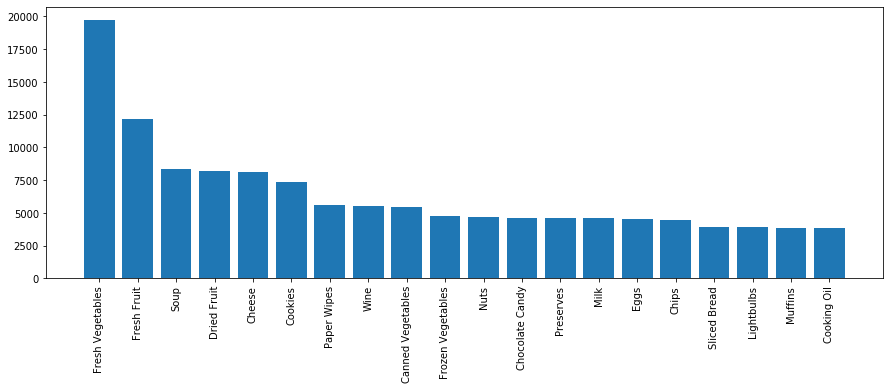

In [273]:
plt.figure(figsize=(15,5))
df_graph = df21_products_frequency.iloc[:20]
plt.bar(df_graph['product'],df_graph['total'])
plt.xticks(rotation=90)

The frequency of most products is very similar to the ones from all stores. We should take in account that the quantity of transactions is half os all transactions, which is a significant part of all transactions.

#### 2.1.2. Compute Frequent Itemsets

In [274]:
X = 0.005
Y = 0.007

In [276]:
frequent_itemsets21_fpg  = fpgrowth(df21_te, min_support=X, use_colnames=True)
frequent_itemsets21_fpg = frequent_itemsets21_fpg.sort_values('support',ascending = False)
frequent_itemsets21_fpg['length'] = frequent_itemsets21_fpg['itemsets'].apply(lambda x: len(x))
frequent_itemsets21_fpg['num_transactions'] = [round(s*len(itemset_21)) for s in frequent_itemsets21_fpg['support']]

In [281]:
frequent_itemsets21_fpg.query(f'length == 2 & support > {Y}')

,support,itemsets,length,num_transactions
126,0.051806,"(Fresh Fruit, Fresh Vegetables)",2,1619
164,0.036191,"(Soup, Fresh Vegetables)",2,1131
111,0.035679,"(Dried Fruit, Fresh Vegetables)",2,1115
206,0.031167,"(Cheese, Fresh Vegetables)",2,974
169,0.030015,"(Cookies, Fresh Vegetables)",2,938
...,...,...,...,...
326,0.007136,"(Dried Fruit, Waffles)",2,223
325,0.007136,"(Soup, Waffles)",2,223
251,0.007136,"(Soup, Chocolate Candy)",2,223
194,0.007040,"(Wine, Cheese)",2,220


#### 2.1.3. Generate Association Rules from Frequent Itemsets

In [305]:
C = 0.3 # Confidence
L = 1.1 # Lift

In [296]:
rules21 = association_rules(frequent_itemsets21_fpg, metric="confidence", min_threshold=0)
rules21['antecedent_len'] = rules21['antecedents'].apply(lambda x: len(x))

In [306]:
generate_fi(rules21, 1, C, L)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
156,(Hard Candy),(Fresh Vegetables),0.028767,0.290071,0.009440,0.328142,1.131250,0.001095,1.056666,1
166,(Aspirin),(Fresh Vegetables),0.027647,0.290071,0.009088,0.328704,1.133185,0.001068,1.057550,1
168,(Sugar),(Fresh Vegetables),0.027423,0.290071,0.009024,0.329055,1.134395,0.001069,1.058103,1
242,"(Soup, Fresh Fruit)",(Fresh Vegetables),0.022399,0.290071,0.008064,0.360000,1.241077,0.001566,1.109265,2
490,(Conditioner),(Fresh Vegetables),0.013888,0.290071,0.005312,0.382488,1.318604,0.001283,1.149662,1
500,(Home Magazines),(Fresh Vegetables),0.014784,0.290071,0.005248,0.354978,1.223765,0.000960,1.100629,1
544,"(Fresh Fruit, Paper Wipes)",(Fresh Vegetables),0.015552,0.290071,0.005024,0.323045,1.113678,0.000513,1.048710,2


#### 2.1.4.  Deluxe/Gourmet Supermarkets versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets).

There is some difference in the results from the association rules but this is most possibly caused by slight variations in the confidence and lift values which filter more cases in the first task.

Overall the difference is insignificant from the general.


### 2.2. Analyse Small Groceries [For groups of 2 and 3]

Here you should analyse **Small Groceries (STORE_ID = 2, 5, 14, 22)**.

#### 2.2.1.  Load/Preprocess the Dataset

**This should be trivial now.**

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.2. Compute Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this 


#### 2.2.3. Generate Association Rules from Frequent Itemsets

In [ ]:
# Write code in cells like this
# ....

Write text in cells like this


#### 2.2.4 Small Groceries versus All Stores

Discuss the similarities and diferences between the results obtained in task 1. (frequent itemsets and association rules found in transactions from all stores) and those obtained above (frequent itemsets and association rules found in transactions only Small Groceries).

Write text in cells like this


### 2.3.  Deluxe/Gourmet Supermarkets versus Small Groceries  [For groups of 2 and 3]

Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions only from Deluxe/Gourmet Supermarkets) and those obtained in task 2.2. (frequent itemsets and association rules found in transactions only Small Groceries).

In [ ]:
# Write code in cells like this
# ....

### 2.4. Analyse Supermarkets [Only for groups of 3]
Here you should analyse Supermarkets (STORE_ID = 1, 3, 7, 10, 11, 15, 16).

Use subsections as in tasks 2.1 and 2.2.



In [ ]:
# Write code in cells like this
# ....

### 2.5. Deluxe/Gourmet Supermarkets versus Supermarkets [Only for groups of 3]
Discuss the similarities and diferences between the results obtained in task 2.1. (frequent itemsets and association rules found in transactions from Deluxe Supermarkets/Gourmet Supermarkets) and the results obtained in task 2.4. (frequent itemsets and association rules found in transactions from Supermarkets).

Write text in cells like this

In [ ]:
# Write code in cells like this
# ....